# Load packages

In [1]:
import os
import gc

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import lightgbm as lgb

import warnings
warnings.simplefilter('ignore', FutureWarning)

print(os.listdir("../input"))

ModuleNotFoundError: No module named 'lightgbm'

# Load datasets

In [2]:
train = pd.read_csv('../input/train.csv', parse_dates=["first_active_month"])
test = pd.read_csv('../input/test.csv', parse_dates=["first_active_month"])
sample_submission = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.shape, test.shape, sample_submission.shape

((201917, 6), (123623, 5), (123623, 2))

In [4]:
train.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749
5,2016-09-01,C_ID_0894217f2f,4,2,0,0.871585
6,2016-12-01,C_ID_7e63323c00,3,2,1,0.230129
7,2017-09-01,C_ID_dfa21fc124,3,2,1,2.135850
8,2017-08-01,C_ID_fe0fdac8ea,2,1,0,-0.065406
9,2016-08-01,C_ID_bf62c0b49d,2,2,0,0.300062


In [5]:
test.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1
5,2017-07-01,C_ID_5814b4f13c,5,1,1
6,2017-10-01,C_ID_a1b3c75277,1,2,0
7,2017-02-01,C_ID_f7cada36d3,3,1,1
8,2017-07-01,C_ID_9d2bc8dfc4,4,3,0
9,2016-03-01,C_ID_6d8dba8475,5,1,1


In [6]:
merchants = pd.read_csv('../input/merchants.csv')
historical_transactions = pd.read_csv('../input/historical_transactions.csv')
new_merchant_transactions = pd.read_csv('../input/new_merchant_transactions.csv')

In [7]:
merchants.shape, historical_transactions.shape, new_merchant_transactions.shape

((334696, 22), (29112361, 14), (1963031, 14))

In [8]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [9]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [10]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


# Preprocessing

In [11]:
def missing_impute(df):
    for i in df.columns:
        if df[i].dtype == "object":
            df[i] = df[i].fillna("other")
        elif (df[i].dtype == "int64" or df[i].dtype == "float64"):
            df[i] = df[i].fillna(df[i].mean())
        else:
            pass
    return df

In [12]:
def datetime_extract(df, dt_col='first_active_month'):
    df['date'] = df[dt_col].dt.date 
    df['day'] = df[dt_col].dt.day 
    df['dayofweek'] = df[dt_col].dt.dayofweek
    df['dayofyear'] = df[dt_col].dt.dayofyear
    df['days_in_month'] = df[dt_col].dt.days_in_month
    df['daysinmonth'] = df[dt_col].dt.daysinmonth 
    df['month'] = df[dt_col].dt.month
    df['week'] = df[dt_col].dt.week 
    df['weekday'] = df[dt_col].dt.weekday
    df['weekofyear'] = df[dt_col].dt.weekofyear
    df['year'] = train[dt_col].dt.year

    return df

In [13]:
# Do impute missing values
for df in [train, test, merchants, historical_transactions, new_merchant_transactions]:
    missing_impute(df)

In [14]:
# Do extract datetime values
train = datetime_extract(train, dt_col='first_active_month')
test = datetime_extract(test, dt_col='first_active_month')

In [15]:
train.shape, test.shape

((201917, 17), (123623, 16))

**Merge train and test with historical transactions**

In [16]:
# Define the aggregation procedure outside of the groupby operation
aggregations = {
    'purchase_amount': ['sum', 'mean', 'std', 'min', 'max', 'size'],
}

grouped = historical_transactions.groupby('card_id').agg(aggregations)
grouped.columns = grouped.columns.droplevel(level=0)
grouped.rename(columns={
    "sum": "sum_purchase_amount", 
    "mean": "mean_purchase_amount",
    "std": "std_purchase_amount", 
    "min": "min_purchase_amount",
    "max": "max_purchase_amount", 
    "size": "num_purchase_amount"}, inplace=True)
grouped.reset_index(inplace=True)

train = pd.merge(train, grouped, on="card_id", how="left")
test = pd.merge(test, grouped, on="card_id", how="left")

del grouped
gc.collect()

84

In [17]:
train.shape, test.shape

((201917, 23), (123623, 22))

**Merge train and test with new_merchant_transactions**

In [18]:
# Define the aggregation procedure outside of the groupby operation
aggregations = {
    'purchase_amount': ['sum', 'mean', 'std', 'min', 'max', 'size'],
}

grouped = new_merchant_transactions.groupby('card_id').agg(aggregations)
grouped.columns = grouped.columns.droplevel(level=0)
grouped.rename(columns={
    "sum": "sum_purchase_amount", 
    "mean": "mean_purchase_amount",
    "std": "std_purchase_amount", 
    "min": "min_purchase_amount",
    "max": "max_purchase_amount", 
    "size": "num_purchase_amount"}, inplace=True)
grouped.reset_index(inplace=True)

train = pd.merge(train, grouped, on="card_id", how="left")
test = pd.merge(test, grouped, on="card_id", how="left")

del grouped
gc.collect()

42

In [19]:
train.shape, test.shape

((201917, 29), (123623, 28))

# Featuring

In [20]:
# One-hot encode features
ohe_df_1 = pd.get_dummies(train['feature_1'], prefix='f1_')
ohe_df_2 = pd.get_dummies(train['feature_2'], prefix='f2_')
ohe_df_3 = pd.get_dummies(train['feature_3'], prefix='f3_')

ohe_df_4 = pd.get_dummies(test['feature_1'], prefix='f1_')
ohe_df_5 = pd.get_dummies(test['feature_2'], prefix='f2_')
ohe_df_6 = pd.get_dummies(test['feature_3'], prefix='f3_')

# Numerical representation of the first active month
train = pd.concat([train, ohe_df_1, ohe_df_2, ohe_df_3], axis=1, sort=False)
test = pd.concat([test, ohe_df_4, ohe_df_5, ohe_df_6], axis=1, sort=False)

del ohe_df_1, ohe_df_2, ohe_df_3
del ohe_df_4, ohe_df_5, ohe_df_6
gc.collect()

14

In [21]:
train.shape, test.shape

((201917, 39), (123623, 38))

In [22]:
excluded_features = ['first_active_month', 'card_id', 'target', 'date']
train_features = [c for c in train.columns if c not in excluded_features]

In [23]:
for f in train_features:
    print(f)

feature_1
feature_2
feature_3
day
dayofweek
dayofyear
days_in_month
daysinmonth
month
week
weekday
weekofyear
year
sum_purchase_amount_x
mean_purchase_amount_x
std_purchase_amount_x
min_purchase_amount_x
max_purchase_amount_x
num_purchase_amount_x
sum_purchase_amount_y
mean_purchase_amount_y
std_purchase_amount_y
min_purchase_amount_y
max_purchase_amount_y
num_purchase_amount_y
f1__1
f1__2
f1__3
f1__4
f1__5
f2__1
f2__2
f2__3
f3__0
f3__1


In [24]:
train.isnull().sum()

first_active_month            0
card_id                       0
feature_1                     0
feature_2                     0
feature_3                     0
target                        0
date                          0
day                           0
dayofweek                     0
dayofyear                     0
days_in_month                 0
daysinmonth                   0
month                         0
week                          0
weekday                       0
weekofyear                    0
year                          0
sum_purchase_amount_x         0
mean_purchase_amount_x        0
std_purchase_amount_x         0
min_purchase_amount_x         0
max_purchase_amount_x         0
num_purchase_amount_x         0
sum_purchase_amount_y     21931
mean_purchase_amount_y    21931
std_purchase_amount_y     48718
min_purchase_amount_y     21931
max_purchase_amount_y     21931
num_purchase_amount_y     21931
f1__1                         0
f1__2                         0
f1__3   

--> Still missing values. So need to fill NA again

In [25]:
for col in train_features:
    for df in [train, test]:
        if df[col].dtype == "float64":
            df[col] = df[col].fillna(df[col].mean())

# Modeling with LightGBM

In [26]:
# Prepare data for training
X = train.copy()
y = X['target']

# Split data with kfold
kfolds = KFold(n_splits=5, shuffle=True, random_state=2018)

# Make importance dataframe
importances = pd.DataFrame()

oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(test.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(kfolds.split(X, y)):
    X_train, y_train = X[train_features].iloc[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X[train_features].iloc[val_idx], y.iloc[val_idx]
    
    # LightGBM Regressor estimator
    model = lgb.LGBMRegressor(
        num_leaves = 31,
        learning_rate = 0.03,
        n_estimators = 1000,
        subsample = .9,
        colsample_bytree = .9,
        random_state = 1
    )
    
    # Fit
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=None, eval_metric='rmse',
        early_stopping_rounds=100
    )
    
    # Feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = model.booster_.feature_importance(importance_type='gain')
    imp_df['fold'] = n_fold + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_idx] = model.predict(X_valid, num_iteration=model.best_iteration_)
    test_preds = model.predict(test[train_features], num_iteration=model.best_iteration_)
    sub_preds += test_preds / kfolds.n_splits
    
mean_squared_error(y, oof_preds) ** .5

3.8043068891902467

# Display feature importances

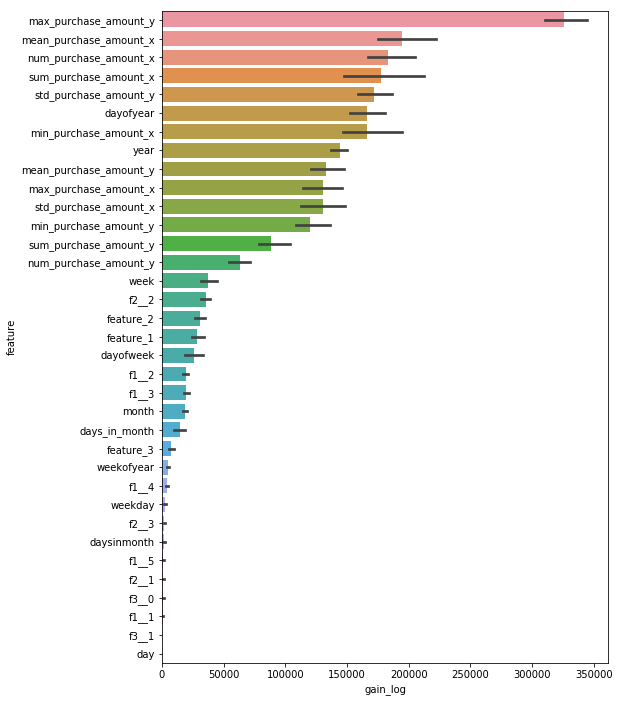

In [27]:
importances['gain_log'] = importances['gain']
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

# Make submission

In [28]:
sub_preds

array([-0.73082872, -0.99850643, -1.28805525, ..., -0.02534378,
       -0.50858971, -0.03309917])

In [29]:
# Make submission 1
sample_submission['target'] = sub_preds
sample_submission.to_csv("submission1.csv", index=False)
sample_submission.head()

,card_id,target
0,C_ID_0ab67a22ab,-0.730829
1,C_ID_130fd0cbdd,-0.998506
2,C_ID_b709037bc5,-1.288055
3,C_ID_d27d835a9f,-0.099780
4,C_ID_2b5e3df5c2,-1.113085


In [30]:
# Make submission 2 - revert from submission 1
sample_submission['target'] = -1*sub_preds
sample_submission.to_csv("submission2.csv", index=False)
sample_submission.head()

,card_id,target
0,C_ID_0ab67a22ab,0.730829
1,C_ID_130fd0cbdd,0.998506
2,C_ID_b709037bc5,1.288055
3,C_ID_d27d835a9f,0.099780
4,C_ID_2b5e3df5c2,1.113085


In [31]:
# Length of submission
len(sub_preds)

123623

In [33]:
# How many positive target values
np.sum(np.array(sub_preds) >= 0, axis=0)


19038

In [34]:
sample_submission

,card_id,target
0,C_ID_0ab67a22ab,0.730829
1,C_ID_130fd0cbdd,0.998506
2,C_ID_b709037bc5,1.288055
3,C_ID_d27d835a9f,0.099780
4,C_ID_2b5e3df5c2,1.113085
5,C_ID_5814b4f13c,0.423457
6,C_ID_a1b3c75277,0.766115
7,C_ID_f7cada36d3,0.755411
8,C_ID_9d2bc8dfc4,1.152085
9,C_ID_6d8dba8475,0.733757
